In [1]:
# Load libraries

# Compatibility between Python 2 and Python 3
from __future__ import division, print_function, unicode_literals, absolute_import

%matplotlib inline
import os
import math
import numpy as np
from brian2 import *

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pandas as pd
from scipy.optimize import curve_fit # for doing regression
from sklearn.metrics import r2_score # for measuring fit error

from Python_Libs.utility_functions import *

SAVE_PLOT = False
figs_path = 'Data/Plots_v2/'
figs_extension = '.svg'

figsize = (3.8, 2.6)

# Colour scheme for plots
colourscheme = 'viridis' # 'viridis' or 'none'

if colourscheme == 'viridis':
    viridis = plt.cm.get_cmap('viridis')

if SAVE_PLOT:
    plt.rcParams.update({'font.size': 10}) # Change the font size


In [2]:
def scale_circ_to_line(theta_ts_list, scale=[(0, 360), (0, 100)]):
    """ Gets 
            theta_ts_list   : a list of an numpy array of arrays
            scale           : a list for conversion from a scale to another scale, eg [(0, 360), (0, 100)]
        Returns
            the time series with the samples scaled according to scale, from range scale[0] to range scale[1]
    """
    if isinstance(theta_ts_list, list):
        theta_ts_list = np.array(theta_ts_list)
    if scale is not None: 
        normalised_theta_ts_list = theta_ts_list / scale[0][1] # [0, 1]
        distance_represented = normalised_theta_ts_list * scale[1][1]
    else:
        distance_represented = theta_ts_list
    return distance_represented

def preprocess_time_series(time_series, t_snapshots, scale=None, plot_from_t=None, normalise_start=None):
    """ Gets 
            time_series     : a list or an numpy array of arrays
            t_snapshots     : an array with the time stamps of the samples in time_series (with units)
            scale           : a list for conversion from a scale to another scale, eg [(0, 360), (0, 100)]
            plot_from_t     : return samples from that time stamp onwards
            normalise_start : normalise all time series to this starting value
        Returns
            a touple with the t_snapshots (shortned if plot_from_t != None) and the processed time_series
    """
    # Scale theta degrees to meters
    if scale is not None:
        distance_represented = scale_circ_to_line(time_series, scale)
    else:
        if isinstance(time_series, list):
            time_series = np.array(time_series)
        distance_represented = time_series
    
    if plot_from_t is not None:
        plot_from_t_index = np.argmin(np.abs(t_snapshots - plot_from_t))
    else:
        plot_from_t_index = 0
    
    if normalise_start is not None: 
        # Shift values so that the curve begins at normalise_start
        distance_represented = distance_represented - (distance_represented[plot_from_t_index] - normalise_start)
    
    #return ((t_snapshots/second)[plot_from_t_index:], distance_represented[plot_from_t_index:])
    return (distance_represented[plot_from_t_index:], t_snapshots[plot_from_t_index:])


def MAD2variance(MAD):
    """ Assumes data come from Gaussian distribution """
    variance = MAD**2 / (2 / np.pi)
    return variance

def variance2MAD(variance):
    """ Assumes data come from Gaussian distribution """
    MAD = np.sqrt(variance * (2 / np.pi))
    return MAD

def calc_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, start_time=0, end_time=1, percentage=False, exponent=1, scale=None): 
    """ Gets 
            percentile : False for the maximum and minimum sample value or 
                         a number for calculating the median of the first <number>% samples 
                         and the last <number>% samples.
            scale      : eg scaling mapping to apply before calculating rate scale=[(0, 360), (0, 100)]
            exponent   : eg exponent=1 or exponent=2 power to raise after scalling and before calculating rate. 
                         In reality it is not just a power, if exponent=2 then MAD is converted to variance
                         assuming normally distributed data. 
    """
    if isinstance(start_time, Quantity):
        start_time = start_time / second
    if isinstance(end_time, Quantity):
        end_time = end_time / second
    
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_ts_abs_diff_mean = plot_item['theta_ts_abs_diff_mean']
            
            # Added scaling before calculating rate
            if scale is not None: 
                theta_ts_abs_diff_mean = scale_circ_to_line(theta_ts_abs_diff_mean, scale)
            
            # Since the MAD is proportional to the sqrt of the variance, optionally straighten the curve by raising to the power of 2
            if exponent == 2:
                #theta_ts_abs_diff_mean = theta_ts_abs_diff_mean**exponent # That was a first approximation
                theta_ts_abs_diff_mean = MAD2variance(theta_ts_abs_diff_mean) # convert MAD to variance var=MAD^2/sqrt(2/pi) assuming Gaussian distribution
            t_snapshots = plot_item['t_snapshots']

            if isinstance(t_snapshots, Quantity):
                t_snapshots = t_snapshots / second

            index_start_time = np.argmax(t_snapshots >= start_time)
            index_end_time = np.argmin(t_snapshots <= end_time)
            
            theta_ts_abs_diff_mean_segment = theta_ts_abs_diff_mean[index_start_time:index_end_time]
            
            if not percentage:
                delta_theta_ts_abs_diff_mean_segment = np.max(theta_ts_abs_diff_mean_segment) - np.min(theta_ts_abs_diff_mean_segment)
            else:
                a = theta_ts_abs_diff_mean_segment
                first_portion_median = np.median(a[0:int(len(a)*percentage/100)])
                last_portion_median = np.median(a[len(a)-int(len(a)*percentage/100):len(a)])
                delta_theta_ts_abs_diff_mean_segment = last_portion_median - first_portion_median
            delta_time = end_time - start_time
            
            # If we raised MAD to the power of 2 above take the square root of the result (1/exponent) to get it in meters units
            if exponent == 1:
                theta_mean_absolute_deviation_rate = delta_theta_ts_abs_diff_mean_segment / delta_time
            elif exponent == 2:
                #theta_mean_absolute_deviation_rate = (delta_theta_ts_abs_diff_mean_segment**(1/exponent)) / delta_time # That was a first approximation
                theta_mean_absolute_deviation_rate = variance2MAD(delta_theta_ts_abs_diff_mean_segment) / delta_time # convert MAD to variance var=MAD^2/sqrt(2/pi) assuming Gaussian distribution
            
            plot_items_dict[plot_key]['theta_mean_absolute_deviation_rate'] = theta_mean_absolute_deviation_rate

            # Ignore the previous calculation and use instead line regression
            # This would return MAD^2/second
            y = theta_ts_abs_diff_mean_segment
            x = t_snapshots[index_start_time:index_end_time]
            x = x[:,np.newaxis]
            a, _, _, _ = np.linalg.lstsq(x, y)
            plot_items_dict[plot_key]['theta_mean_absolute_deviation_rate'] = a[0]           
    
    return plot_items_dict

def print_theta_mean_absolute_deviation_rate(plot_items_dict, plot_keys_list, plot_key_str, plot_key_units):
    c1w = max(len(plot_key_str), len(plot_key_units))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_str,  'Drift rate'))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_units, '(°/s)'))
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_mean_absolute_deviation_rate = plot_item['theta_mean_absolute_deviation_rate']
            print(('{:'+str(c1w)+'} {:10}').format(plot_key, theta_mean_absolute_deviation_rate))


def print_theta_mean_absolute_deviation_rate_scaled(plot_items_dict, plot_keys_list, plot_key_str, plot_key_units, scale=[(0, 360), (0, 100)]):
    c1w = max(len(plot_key_str), len(plot_key_units))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_str,  'Drift rate'))
    print(('{:^'+str(c1w)+'} {:^10}').format(plot_key_units, '(units/s)'))
    for plot_key in plot_keys_list:
        plot_item = plot_items_dict[plot_key]
        if plot_item is not None:
            theta_mean_absolute_deviation_rate = plot_item['theta_mean_absolute_deviation_rate']
            distance_represented_mean_absolute_deviation_rate = scale_circ_to_line(theta_mean_absolute_deviation_rate, scale)
            print(('{:'+str(c1w)+'} {:10}').format(plot_key, distance_represented_mean_absolute_deviation_rate))


In [3]:
def func_lin_1(x, a, b):
    """ Line function """
    y = a * x + b
    return y

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

def func_exp_2(x, a, b, c, d):
    """ Exponential function """
    y = d - a * np.exp(-b*x) + c
    return y

def regress(data_x, data_y, func, params0, func_str = None, bounds = (-inf, inf), x_range_min=None, x_range_max=None):
    """
        data_x  : The x data point sample values to fit the function to
        data_y  : The y data point sample values to fit the function to
        func    : Function used for regression
        params0 : Initial guess of function parameter values to optimize
    """
    
    params, conv  = curve_fit(func, data_x, data_y, params0, bounds = bounds) # fit function parameters
    
    # Print the fitted parameters
    if func_str is not None:
        print('Optimal parameters')
        print(func_str.format(params))
    
    # Calculate fitted curve prediction
    y_prime = func(data_x, *params)
    # Calculate r^2
    r2 = r2_score(data_y, y_prime)
    print('R^2 = {}'.format(r2))
    
    # Return a fitted curve for enough sample points to make it smooth for plotting
    if x_range_min is None:
        x_range_min = np.min(data_x)
    if x_range_max is None:
        x_range_max = np.max(data_x)
    # Grenerate x axis values
    x_prime = np.linspace(x_range_min, x_range_max, num=1000, endpoint=True)
    # Calculate fitted curve prediction
    y_prime = func(x_prime, *params)
    
    return x_prime, y_prime, params, r2


### Effect of neuronal time constant on bump stability 

In [4]:
input_path = 'Data/'
input_file = 'collected-unwrapped-NMDA-TAU.npy' # This is the unwrapped recordings with various tau values

input_filename = os.path.join(input_path, input_file)

if os.path.exists(input_filename):
    # Save all data in the file
    data = np.load(input_filename, allow_pickle=True, encoding='bytes')
else: 
    print('ERROR: File does not exist: {:s}'.format(input_filename))

In [5]:
# The above loaded data from the file to the variable data has the following structure:
#     data[()][model][poisson_neuron_noise][neurons_num].keys()    (option 1)
#     data.item()[model][poisson_neuron_noise][neurons_num].keys() (option 2)
#          model = ['NMDA', 'EC_LV_1'][0]
#          poisson_neuron_noise = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009][0]
#          neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][0]
#  eg data.item()['NMDA'][0.001][1024]['theta_ts_list'] = time_series_collection
# The way to access and explore the dict entries in the the variable data is
#     data[()].keys()
#     or
#     data.item().keys()
model = ['NMDA', 'EC_LV_1', 'SIMPLE'][2]
poisson_neuron_noise = [0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.100][5]
model = ['NMDA', 'EC_LV_1', 'SIMPLE', 'SIMPLE-TAU2', 'NMDA-TAU'][4]
poisson_neuron_noise = [0.0001, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.100, 1.0, 1.4][13]
neurons_num = [128, 256, 512, 1024, 2048, 4096, 8192][1]
tau = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms', '100000ms'][4]
#data.item()[model][poisson_neuron_noise][tau][neurons_num].keys()
data.item()[model][poisson_neuron_noise][tau][neurons_num].keys()

dict_keys(['theta_ts_list', 'theta_ts_abs_diff_mean', 'theta_ts_abs_diff_std', 't_snapshots', 'stimulus_center_deg', 'N_excitatory', 'idx_monitored_neurons_excit'])

Trials tau=0.5ms n=398
Trials tau=1ms n=336
Trials tau=5ms n=299
Trials tau=10ms n=380
Trials tau=20ms n=368
Trials tau=30ms n=407
Trials tau=40ms n=420
Trials tau=50ms n=386
Trials tau=60ms n=365
Trials tau=70ms n=373
Trials tau=80ms n=212
Trials tau=90ms n=250
Trials tau=100ms n=291


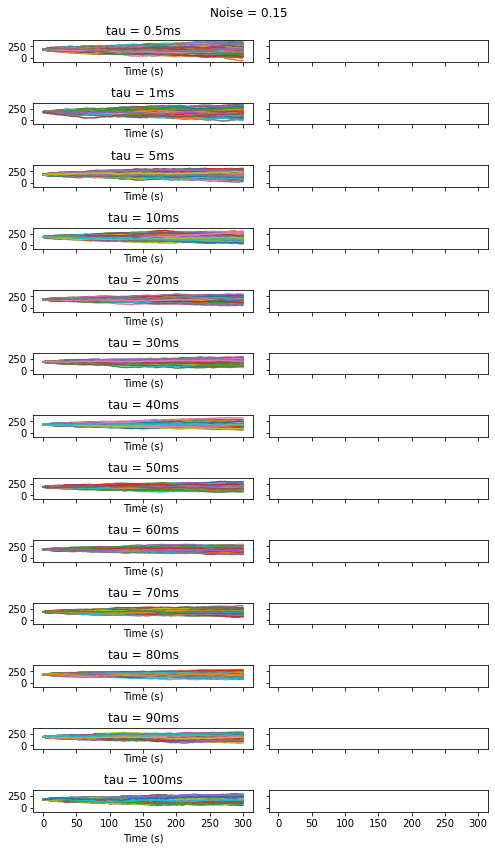

In [6]:
# Plot each experimental condition in separate plot
#noise=0.002 Dispersion seems to be decreasing with tau value for tau 10-1000 not for 10000
#noise=0.005 There does not seem to be difference between tau values
#noise=0.008 Very noisy. Dispersion maybe decreases with tau value but it is very noisy

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[0]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, 
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

show_option = 1 # Plot with poisson_neuron_noise=1.4 and neurons_nums=256
show_option = 2 # Plot with poisson_neuron_noise=0.3 and neurons_nums=256
show_option = 3 # Plot with poisson_neuron_noise=0.15 and neurons_nums=512
#show_option = 4 # Plot with poisson_neuron_noise=0.05 and neurons_nums=512
            
models = ['SIMPLE']  # List of the neuron models present in the collected recordings file
models = ['SIMPLE-TAU2']
models = ['NMDA-TAU']
poisson_neuron_noises = [0.002] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [0.0, 0.0001, 0.001, 0.005, 0.010, 0.100] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [1.0]

if show_option == 1:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
    taus = ['complex', '1ms', '10ms', '50ms', '100ms', '500ms', '1000ms', '5000ms', '10000ms', '50000ms', '100000ms'][1:]
    taus = ['complex', '1ms', '10ms', '100ms', '1000ms', '10000ms', '100000ms'][2:7]
    taus = ['complex', '1ms', '10ms', '100ms', '1000ms', '10000ms', '100000ms'][1:4]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '50ms', '100ms', '1000ms', '10000ms', '100000ms'][1:7]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:14]
    # temp
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '50ms', '80ms', '100ms', '1000ms', '10000ms', '100000ms'][1:10]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:12]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:14]

# Newly collected data with 256 neurons
if show_option == 2:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.3]
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]

# Newly collected data with 512 neurons
if show_option == 3:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]

if show_option == 4:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'][1:]


#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot


for poisson_neuron_noise in poisson_neuron_noises:
    fig, axs = plt.subplots(nrows=len(taus), ncols=2, figsize=(7, 12), sharex=True, sharey=True)
    
    for indx_i, model in enumerate(models):
        for indx_j, tau in enumerate(taus):
            # Get reference to the appropriate subplot
            ax = axs[indx_j, indx_i]
            try: 
                # Get the list of theta recordings time series
                theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
                t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
                theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
                theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']

                fig.suptitle('Noise = ' + str(poisson_neuron_noise))

                if plot_type == plot_types[0]: # Plot theta_ts_list
                    print('Trials tau={:} n={:}'.format(tau, len(theta_ts_list)))
                    #theta_ts_list = theta_ts_list[:134]
                    for i, ts in enumerate(theta_ts_list):
                        ax.plot(t_snapshots, ts)
                        ax.set_title('tau = ' + str(tau))
                        ax.set_xlabel('Time (s)')
                        #ax.set_ylim((0, 360))

                if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                    ax.plot(t_snapshots, theta_ts_abs_diff_mean)
                    ax.set_title('tau = ' + str(tau))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))

                if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                    ax.plot(t_snapshots, theta_ts_abs_diff_std)
                    ax.set_title('tau = ' + str(tau))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))
            except:
                pass

    fig.tight_layout()

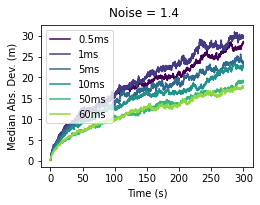

In [7]:
# Plot experimental conditions collated in combined plots
# Noise = 0.005 seems to be a nice choise
# The jump at the EC_LV_1 with N=128 corresponds to 0.622 neurons, so it is a jump to the middle in average

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[1]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, (In this version there is not much point of using this option because it will plot all network sizes in the same plot)
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

plot_option = 1 # Plot with poisson_neuron_noise=1.4 and neurons_nums=256
#plot_option = 2 # Plot with poisson_neuron_noise=0.3 and neurons_nums=256
#plot_option = 3 # Plot with poisson_neuron_noise=0.15 and neurons_nums=512
#plot_option = 4 # Plot with poisson_neuron_noise=0.05 and neurons_nums=512


models = ['SIMPLE']  # List of the neuron models present in the collected recordings file
models = ['SIMPLE-TAU2']
models = ['NMDA-TAU']
poisson_neuron_noises = [0.002] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [0.0, 0.0001, 0.001, 0.005, 0.010, 0.100] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [1.0]

if plot_option == 1:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:13]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '50ms', '60ms'][1:]

#taus = ['0.5ms', '1ms', '10ms', '40ms', '50ms', '80ms']

# Newly collected data with 256 neurons - These data look very bad worse than with possion_noise=1.4
if plot_option == 2:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.3]
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]
    taus = ['complex', '1ms', '10ms', '50ms'][1:]
    taus = ['complex', '1ms', '10ms', '20ms', '80ms'][1:]

# Newly collected data with 512 neurons - These data use more neurons for having less poisson_noise and 
# look as goood as the 256 neurons with poisson_noise=1.4
if plot_option == 3:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]
    taus = ['complex', '1ms', '10ms', '50ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    taus = ['complex', '0.5ms', '1ms', '10ms', '30ms', '40ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    #taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '30ms', '40ms'][1:] # The 5ms sample has a funny drop in error after 250s probably an unwrapping issue
    # To try without unwrapping if 5ms shows up ok. It looks the same.
    
# Newly collected data with 512 neurons - These data use more neurons for having even less poisson_noise and 
# look as goood as the 256 neurons with poisson_noise=1.4
if plot_option == 4:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'][1:]
    taus = ['complex', '1ms', '10ms', '40ms', '60ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    taus = ['complex', '0.5ms', '1ms', '10ms', '40ms', '60ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    # To collect and include 5ms trials

#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot


# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_mapping_units = 'Mean Absolute Deviation (m)'
plot_mapping_units = 'Mean Abs. Dev. (m)'
plot_mapping_units = 'Median Abs. Dev. (m)'
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = None
plot_from_t = None

# Colour scheme for plots
colourscheme = 'viridis' # 'viridis' or 'none'

if colourscheme == 'viridis':
    viridis = plt.cm.get_cmap('viridis')
    #viridis = plt.cm.get_cmap('Greys')
    
for poisson_neuron_noise in poisson_neuron_noises:
    #if SAVE_PLOT:
    #    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharex=True, sharey=True)
    #else:
    #    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3.5), sharex=True, sharey=True)
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    for indx_i, model in enumerate(models):
        for indx_j, tau in enumerate(taus):
            # Get reference to the appropriate subplot
            #ax = axs[indx_i]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']
            
            if not SAVE_PLOT:
                fig.suptitle('Noise = ' + str(poisson_neuron_noise))
            
            # In this version there is not much point of using this option because it will plot all network sizes in the same plot
            if plot_type == plot_types[0]: # Plot theta_ts_list
                ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                for i, ts in enumerate(ts_list):
                    ax.plot(t_snaps/second, ts)
                    ax.set_title('$\tau$ = ' + str(tau))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))
                    ax.set_ylabel(plot_mapping_units)

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_mean, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(taus))
                    ax.plot(t_snaps/second, ts_list, label=tau, color=colour)
                else: 
                    ax.plot(t_snaps/second, ts_list, label=tau)
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_std, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(taus))
                    ax.plot(t_snaps/second, ts_list, label=tau, color=colour)
                else:
                    ax.plot(t_snaps/second, ts_list, label=tau)
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

    #fig.tight_layout()
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_tau_on_dispersion_range100m' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num) + figs_extension), bbox_inches='tight', dpi=300)

        

Plot the curves with MAD values raised to the power of 2


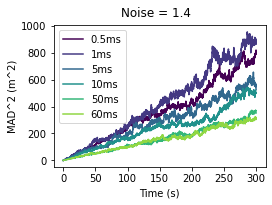

In [8]:
# Plot experimental conditions collated in combined plots
# Noise = 0.005 seems to be a nice choise
# The jump at the EC_LV_1 with N=128 corresponds to 0.622 neurons, so it is a jump to the middle in average

MAD_to_power = 2 # Raise the MASD values to that power, default 1
print('Plot the curves with MAD values raised to the power of', MAD_to_power)

# Choose what to plot
plot_types = ['theta', 'abs_diff_mean', 'abs_diff_std']
plot_type = plot_types[1]                       # Choose what to plot 
                                                #       'theta': theta_ts_list, (In this version there is not much point of using this option because it will plot all network sizes in the same plot)
                                                #       'abs_diff_mean': theta_ts_abs_diff_mean, 
                                                #       'abs_diff_std': theta_ts_abs_diff_std

plot_option = 1 # Plot with poisson_neuron_noise=1.4 and neurons_nums=256
#plot_option = 2 # Plot with poisson_neuron_noise=0.3 and neurons_nums=256
#plot_option = 3 # Plot with poisson_neuron_noise=0.15 and neurons_nums=512
#plot_option = 4 # Plot with poisson_neuron_noise=0.05 and neurons_nums=512


models = ['SIMPLE']  # List of the neuron models present in the collected recordings file
models = ['SIMPLE-TAU2']
models = ['NMDA-TAU']
poisson_neuron_noises = [0.002] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [0.0, 0.0001, 0.001, 0.005, 0.010, 0.100] # List of the neuron noise present in the collected recordings file
poisson_neuron_noises = [1.0]

if plot_option == 1:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms', '1000ms', '10000ms', '100000ms'][1:13]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '50ms', '60ms'][1:]

#taus = ['0.5ms', '1ms', '10ms', '40ms', '50ms', '80ms']

# Newly collected data with 256 neurons - These data look very bad worse than with possion_noise=1.4
if plot_option == 2:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.3]
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]
    taus = ['complex', '1ms', '10ms', '50ms'][1:]
    taus = ['complex', '1ms', '10ms', '20ms', '80ms'][1:]

# Newly collected data with 512 neurons - These data use more neurons for having less poisson_noise and 
# look as goood as the 256 neurons with poisson_noise=1.4
if plot_option == 3:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms'][1:]
    taus = ['complex', '1ms', '10ms', '50ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    taus = ['complex', '0.5ms', '1ms', '10ms', '30ms', '40ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    #taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '30ms', '40ms'][1:] # The 5ms sample has a funny drop in error after 250s probably an unwrapping issue
    # To try without unwrapping if 5ms shows up ok. It looks the same.
    
# Newly collected data with 512 neurons - These data use more neurons for having even less poisson_noise and 
# look as goood as the 256 neurons with poisson_noise=1.4
if plot_option == 4:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'][1:]
    taus = ['complex', '1ms', '10ms', '40ms', '60ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    taus = ['complex', '0.5ms', '1ms', '10ms', '40ms', '60ms'][1:] # Above 20ms overlaps with 20ms and 100ms overlaps with 10ms. Above 80ms plots seem to be more noisy than with lower taus.
    # To collect and include 5ms trials

#model = models[0]                               # Choose which neuron model results to plot
#poisson_neuron_noise = poisson_neuron_noises[0] # Choose what neuron noise results to plot
neurons_num = neurons_nums[0]                   # Choose which network size results to plot


# Mapping of the time series into a custom range (from theta={0,360} to eg m={0,100})
plot_mapping_units = 'Mean Absolute Deviation (m)'
plot_mapping_units = 'Mean Abs. Dev. (m)'
plot_mapping_units = 'Median Abs. Dev. (m)'
plot_mapping_units = 'MAD^2 (m^2)'
plot_scale_mapping = [(0, 360), (0, 100)]
normalise_start = None
plot_from_t = None

# Colour scheme for plots
colourscheme = 'viridis' # 'viridis' or 'none'

if colourscheme == 'viridis':
    viridis = plt.cm.get_cmap('viridis')
    #viridis = plt.cm.get_cmap('Greys')
    
for poisson_neuron_noise in poisson_neuron_noises:
    #if SAVE_PLOT:
    #    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharex=True, sharey=True)
    #else:
    #    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3.5), sharex=True, sharey=True)
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    for indx_i, model in enumerate(models):
        for indx_j, tau in enumerate(taus):
            # Get reference to the appropriate subplot
            #ax = axs[indx_i]
            # Get the list of theta recordings time series
            theta_ts_list = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_list']
            t_snapshots = data[()][model][poisson_neuron_noise][tau][neurons_num]['t_snapshots']
            theta_ts_abs_diff_mean = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_mean']
            theta_ts_abs_diff_std = data[()][model][poisson_neuron_noise][tau][neurons_num]['theta_ts_abs_diff_std']
            
            if not SAVE_PLOT:
                fig.suptitle('Noise = ' + str(poisson_neuron_noise))
            
            # In this version there is not much point of using this option because it will plot all network sizes in the same plot
            if plot_type == plot_types[0]: # Plot theta_ts_list
                ts_list, t_snaps = preprocess_time_series(theta_ts_list, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                for i, ts in enumerate(ts_list):
                    ax.plot(t_snaps/second, ts)
                    ax.set_title('$\tau$ = ' + str(tau))
                    ax.set_xlabel('Time (s)')
                    #ax.set_ylim((0, 360))
                    ax.set_ylabel(plot_mapping_units)

            if plot_type == plot_types[1]: # Plot theta_ts_abs_diff_mean
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_mean, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(taus))
                    # Was: ax.plot(t_snaps/second, ts_list, label=tau, color=colour)
                    ax.plot(t_snaps/second, np.power(ts_list, MAD_to_power), label=tau, color=colour)
                else: 
                    ax.plot(t_snaps/second, ts_list, label=tau)
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

            if plot_type == plot_types[2]: # Plot theta_ts_abs_diff_std
                ts_list, t_snaps = preprocess_time_series(theta_ts_abs_diff_std, t_snapshots, scale=plot_scale_mapping, plot_from_t=None, normalise_start=None)
                if colourscheme == 'viridis': 
                    colour = viridis(indx_j/len(taus))
                    ax.plot(t_snaps/second, ts_list, label=tau, color=colour)
                else:
                    ax.plot(t_snaps/second, ts_list, label=tau)
                #ax.set_title('N = ' + str(neurons_num))
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(plot_mapping_units)
                #ax.set_ylim((0, 360))
                ax.legend()

    #fig.tight_layout()
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_effect_of_tau_on_dispersion_range100m' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num) + figs_extension), bbox_inches='tight', dpi=300)


WARNING    /var/folders/2c/3b_6_35s5wgc5bhfz2wsm1dh0000gn/T/ipykernel_42496/3775210852.py:119: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, _, _, _ = np.linalg.lstsq(x, y)
 [py.warnings]



Noise = 1.4

NMDA-TAU neuron model
---------------------
Scaled output
---------------------
Neurons Drift rate
number    (°/s)   
5ms     3.0071356175234003
10ms    2.4955807661798164
20ms    2.484348867591977
30ms    1.714071091030277
40ms    1.663968407761724
50ms    1.686458950119636
60ms    1.5894994895481402
80ms    1.6177605967497664
90ms    1.7632343430579234
Max tolerable drift rate 0.539m^2/h (0.00014972222222222223m^2/s)
Optimal parameters
y=(1/(x^2))*a, [a] = [91.31691819]
R^2 = -10.121957930223385
For ensuring drift of less than 0.539m^2/h (0.00014972222222222223m^2/s) we need 4073603146 excitatory neurons
Optimal parameters
y=(1/(x^2))*a, [a] = [91.31691819]
R^2 = -10.121957930223385
For ensuring drift of less than 0.539^2m/h (0.00014972222222222223m^2/s) we need a time constant of 4073603.1463570613s


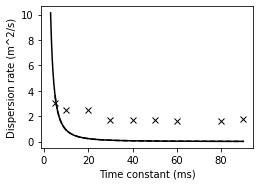

In [9]:
# Calculates the drift rates (Median of Abs. Diff.) of the curves for different tau values and 
# fits an exponential curve to the resulting data points and 
# then predicts what tau would give us the 3.4cm/h drift rate of ants. (This was used in the original version of the paper)

# Optional placed temporalily here to use only a subset different than the above plot
# With this subset of taus produces better fitted curve because above 60ms the drift rate increases again
# option : 1-11 are for poisson_neuron_noise=1.4 and neurons_nums=256
# option : 12-20 are for poisson_neuron_noise=0.15 and neurons_nums=512
# option : 21- are for poisson_neuron_noise=0.05 and neurons_nums=512
option = 10 # Good with 256 neurons at poisson_neuron_noise=1.4  achieves 0.034m/h with tau=62117s
#option = 14 # Good with 512 neurons at poisson_neuron_noise=0.15 achieves 0.034m/h with tau=1829s
#option = 20 # Good with 512 neurons at poisson_neuron_noise=0.15  achieves 0.034m/h with tau=20603566s
#option = 21  # Good with 512 neurons at poisson_neuron_noise=0.05  achieves 0.034m/h with tau=28s

if option >= 1 and option <= 11:
    neurons_nums = [256] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [1.4]
elif option >= 12 and option <=20:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.15]
elif option >= 21:
    neurons_nums = [512] # List of the network sizes present in the collected recordings file
    poisson_neuron_noises = [0.05]

neurons_num = neurons_nums[0]

# option == 1 # 0.336s R2=0.504
if option == 1 or option == 3 or option == 4:
    # Option 1 & 3
    # Option 1 : 0.6247697408821746s
    # Option 3 : 4.98631052591893s
    taus = ['complex', '0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'][1:]
    start_time=0
    end_time=200
    percentage=0.1
if option == 2: # 30s R2=0.831
    # Option 2
    # Option 2 : 5510.134952119207s Somehow in the past got that with option 2 one of the values must have been different
    taus = ['complex', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms'][1:]
    start_time=10
    end_time=200
    percentage=0.1
if option == 3: # 2.151s R2=0.682
    start_time=0
    end_time=250
    percentage=0.1
if option == 4: # 2.163s R2=0.685
    start_time=0
    end_time=250
    percentage=0.2
if option == 5: # 2.21s R2=0.635
    start_time=0
    end_time=250
    percentage=0.2
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 6: # 1.191s R2=0.625
    start_time=0
    end_time=258
    percentage=0.18
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']
if option == 7: # 1.223s R2=0.456
    start_time=2
    end_time=235
    percentage=0.30
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 8: # High but not good fit to data points
    start_time=100
    end_time=220
    percentage=0.2
    taus = ['0.5ms', '1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms', '100ms']

# Exploratory
if option == 9: # High but not good fit to data points
    start_time=150
    end_time=250
    percentage=0.15
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms']

# Exploratory
if option == 10: # 62117.584s R2=0.761 A good selection? 
    start_time=20
    end_time=235
    percentage=0.11
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms
    
    start_time=0
    end_time=299
    percentage=0.0
    taus = [       '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms and 1ms and 5ms

# Exploratory
if option == 11: # High but not good fit to data points
    start_time=150
    end_time=299
    percentage=0.1
    taus = ['1ms', '5ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '80ms', '90ms'] # Without 70ms

# Exploratory with the new 512 neurons data set
if option == 12: #     9.296s    R2=0.515
    start_time=0
    end_time=250
    percentage=0.38
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 13: #    47.830s    R2=0.605
    start_time=10
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 14: # 1829.647s    R2=0.651
    start_time=20
    end_time=250
    percentage=0.25
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms Without 0.5ms => 1830s
    #taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms With 0.5ms 1595s
# Exploratory with the new 512 neurons data set
if option == 15: #  1810.837s    R2=0.629
    start_time=20
    end_time=250
    percentage=0.40
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 16: # High but not good fit to data points
    start_time=80
    end_time=240
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 17: # High but not good fit to data points
    start_time=80
    end_time=250
    percentage=0.10
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 18: # High but not good fit to data points
    start_time=80
    end_time=270
    percentage=0.24
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 19: # High but not good fit to data points
    start_time=90
    end_time=250
    percentage=0.28
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms
# Exploratory with the new 512 neurons data set
if option == 20: # 20603566.267s    R2=0.745 A wide range of values with lot of good nicelly gathered points around fitted curve 
    start_time=12
    end_time=245
    percentage=0.15
    taus = ['1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms', '90ms'] # Without 100ms

# Exploratory with the new 512 neurons data set at poisson_noise=0.05
if option == 21: # 1.044s    R2=0.916
    start_time=110
    end_time=299
    percentage=0.10
    taus = ['0.5ms', '1ms', '10ms', '20ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '50ms', '60ms', '70ms', '80ms'] 
    taus = ['0.5ms', '1ms', '10ms', '30ms', '40ms', '60ms', '70ms'] 
    
def calc_drift_rate(poisson_neuron_noises, models, taus, start_time=0, end_time=200, percentage=0.1):
    results_data = {}
    for poisson_neuron_noise in poisson_neuron_noises:
        # Collect data for plot
        results_data[poisson_neuron_noise] = dict()
        print()
        print('Noise = ' + str(poisson_neuron_noise))
        for indx_i, model in enumerate(models):
            print()
            print(model + ' neuron model')
            print('=====================')
            trials_dict = data[()][model][poisson_neuron_noise]
            trials_dict_remapped = {}
            for tau in taus:
                trials_dict_remapped[tau] = data[()][model][poisson_neuron_noise][tau][neurons_num]
            
            scale=[(0, 360), (0, 100)] # None or a mapping
            trials_dict_ammended = calc_theta_mean_absolute_deviation_rate(trials_dict_remapped, taus, start_time=start_time, end_time=end_time, percentage=percentage, exponent=2, scale=scale)
            if scale is None: 
                print('---------------------')
                print('Not scaled output')
                print('---------------------')
            else: 
                print('---------------------')
                print('Scaled output')
                print('---------------------')
                
            print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Neurons', plot_key_units='number')
            #print_theta_mean_absolute_deviation_rate(trials_dict_ammended, taus, plot_key_str='Noise', plot_key_units='(1/SNR)')
            #print('---------------------')
            #print('Scaled output')
            #print('---------------------')
            #print_theta_mean_absolute_deviation_rate_scaled(trials_dict_ammended, taus, scale=[(0, 360), (0, 100)], plot_key_str='Neurons', plot_key_units='number')

            # Collect data for plot
            results_data[poisson_neuron_noise][model] = dict()
            results_data[poisson_neuron_noise][model]['x'] = []
            results_data[poisson_neuron_noise][model]['y'] = []
            for tau in taus:
                results_data[poisson_neuron_noise][model]['x'].append(tau.replace('ms', ''))
                results_data[poisson_neuron_noise][model]['y'].append(trials_dict_ammended[tau]['theta_mean_absolute_deviation_rate'])
    return results_data

results_data = calc_drift_rate(poisson_neuron_noises, models, taus, start_time=start_time, end_time=end_time, percentage=percentage)

# Option ?
# New attempt
# Fit curves to the data points
# Drift rate in meters/sec

#plt.rcParams.update({'font.size': 14}) # Change the font size

# Requirements calculation:
t_req = 60 * 60 # Default t_req = 1h
drift_max_percent = 0.01 # Default 1%

# Set condition
condition = 2 # condition = 1 or 2: 1 is for 1m/100m while 2 for 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
if condition == 1:
    t_req = 60 * 60 # t_req = 1h
    drift_max_percent = 0.01 # 1% => 1m/100m
if condition == 2:
    t_req = 60 * 60 # t_req = 1h
    #drift_max_percent = 0.00034 # 0.034% => 0.034m/100m (matching Cataglyphis fortis data Ziegler 1997)
    drift_max_percent = 0.539 # m^2/hour (alt)

range_max = 360
range_max_new = 100

#drift_max = drift_max_percent * range_max_new
drift_max = drift_max_percent #  (alt)

drift_rate_max = drift_max / t_req
x_req = drift_rate_max
print('Max tolerable drift rate {}m^2/h ({}m^2/s)'.format(drift_max, drift_rate_max))

def func_exp_1(x, a, b, c):
    """ Exponential function """
    y = a * np.exp(-b*x) + c
    return y

def func_x2_inv(x, a):
    """ Exponential function """
    y = (1/x**2)*a                                #     option=10: R^2= with a=
    return y

def func_sqrtx_inv(x, a):
    """ Exponential function """
    y = (1/np.sqrt(x))*a                                #     option=10: R^2= with a=
    return y

func_fit = func_x2_inv

func_fit_str = 'y=(1/(x^2))*a, [a] = {}'
#func_fit_str = 'y=(1/sqrt(x))*a, [a] = {}'


# Plot only for 0.005 synaptic noise
#poisson_neuron_noise = 0.005
#poisson_neuron_noise = 0.0001
#poisson_neuron_noise = 1.0
#poisson_neuron_noise = 1.4
#poisson_neuron_noises = [1.4]

# Newly collected data with 256 neurons
#poisson_neuron_noises = [0.3]

# Newly collected data with 512 neurons
#poisson_neuron_noises = [0.15]

poisson_neuron_noise = poisson_neuron_noises[0]

for indx_i, model in enumerate(models):

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    
    y = np.array(results_data[poisson_neuron_noise][model]['y'])
    x = np.array(results_data[poisson_neuron_noise][model]['x'])
    x = x.astype(np.float) # Convert the array of strings to array of numbers
    #y = scale_circ_to_line(y, scale=[(0, range_max), (0, range_max_new)])
    
    # Plot data points
    #plt.plot(x, y, linestyle='', marker='.', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.plot(x, y, 'xk', label='Measured ' + str(poisson_neuron_noise)+' 1/SNR')
    plt.ylabel('Dispersion rate (m/s)')
    plt.xlabel('Time constant (ms)')
    
    # Fit a curve to the data points
    params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA':
        params0 = [1] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'EC_LV_1':
        params0 = [0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE':
        params0 = [0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'SIMPLE-TAU2':
        params0 = [0] # Initial guess of parameter values to optimize [a, b, c]
    if model == 'NMDA-TAU':
        params0 = [0] # Initial guess of parameter values to optimize [a, b, c]
        #params0 = [4946.138,     69.046,   -4.955]
        
    # Method 1
    Method1 = True
    if Method1:
        params, conv  = curve_fit(func_fit, x, y, params0) # fit function parameters
        # Print the fitted parameters
        print('Optimal parameters')
        print(func_fit_str.format(params))
        # Calculate fitted curve prediction
        y_prime = func_fit(x, *params)
        # Calculate r^2
        print('R^2 = {}'.format(r2_score(y, y_prime)))
            # Calculate required number of neurons
        y_req = func_fit(x_req, *params)
        print('For ensuring drift of less than {}m^2/h ({}m^2/s) we need {} excitatory neurons'.format(drift_max, x_req, int(np.round(y_req))))
        # Plot fitted curve for more sample points to make it smooth
        #x_prime = np.linspace(np.min(x), np.max(x), num=1000, endpoint=True)
        max_lim = 1
        max_lim = np.max(x)
        min_lim = np.min(x) - 2
        x_prime = np.linspace(min_lim, max_lim, num=1000, endpoint=True)
        # Calculate fitted curve prediction
        y_prime = func_fit(x_prime, *params)
        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '-k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    
    # Method 2
    Method2 = True
    if Method2:
        x_prime, y_prime, params, r2 = regress(x, y, func_fit, params0, func_str = func_fit_str)
        y_req = func_fit(x_req, *params)
        print('For ensuring drift of less than {}^2m/h ({}m^2/s) we need a time constant of {}s'.format(drift_max, x_req, y_req/1000))

        #plt.plot(x_prime, y_prime, linestyle='-', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
        plt.plot(x_prime, y_prime, '--k', label='Predicted ' + str(poisson_neuron_noise)+' 1/SNR')
    
    # 
    #plt.legend(loc='best')
    plt.ylabel('Dispersion rate (m^2/s)')
    plt.xlabel('Time constant (ms)')
    #plt.xlim([0, max_lim])
    
    if SAVE_PLOT:
        fig.savefig(os.path.join(figs_path, 'pub_' + model + '_neuron_tau_vs_dispersion_rate_range' + str(range_max_new) + 'm' + '_noise' + str(poisson_neuron_noise) + '_neurons' + str(neurons_num)+ '_meas' + str(start_time) + '-' + str(end_time) + 's' + '-' + str(percentage) + 'prc' + '_projtau' + str(int(np.round(y_req/1000))) + 's' + figs_extension), bbox_inches='tight', dpi=300)
        